# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_mdn_31_03_ratio'


print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_mdn_31_03_ratio


In [5]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [6]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished


In [11]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [89]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.7616, 1.9337, 3.1004, 2.4460, 1.6778, 2.7853, 3.3039, 1.9959, 2.1447,
        5.3794, 0.8462, 1.9895, 2.1556, 3.9606, 5.1536])
tensor([ 9.4685,  8.5739, 20.4688,  9.7190, 88.3154, 54.4314, 30.6930, 28.8210,
         5.5235, 72.1460,  2.2050, 66.1613, 96.9680, 41.0795, 40.5550])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[30.1967,  4.0227,  3.2847,  1.6366,  1.8090,  2.5163, 10.5818,  2.4587,
          2.1973, 14.5891,  3.9312,  0.8042,  3.1197,  6.5495, 21.0192]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 5.3868,  5.0474,  1.4399,  6.1161,  4.7002,  6.7180,  6.2547, 10.3301,
         5.2786,  9.5510,  5.1957,  6.1417,  2.5523,  5.1157,  5.8166])
tensor([ 9.6714,  7.8266, 20.5358, 14.7384, 74.2517, 34.9501, 39.6563, 65.6029,
        17.1888, 69.6239,  9.5080, 87.1259, 92.4828, 32.1092, 26.2265])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[3.4578e+01, 1.2288e+01, 3.1559e-01, 2.7619e+01, 1.3300e+02, 2.2116e+02,
         9.7318e+01, 7.9561e+02, 9.8741e+01, 4.2925e+01, 2.1511e+01, 2.3970e+02,
         2.3057e+01, 4.2085e+01, 1.9088e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.7694, 3.2857, 6.0163, 3.0829, 1.0194, 2.5785, 3.0420, 3.4025, 1.3425,
        4.5350, 3.5994, 1.8389, 2.2817, 3.7807, 6.7807])
tensor([ 5.6360,  7.2679, 40.8092, 20.5010, 90.5372, 54.5019, 36.2494, 14.7197,
         8.6165, 57.0734, 10.0402, 70.6244, 96.1363, 38.1978, 61.7683])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[5.7904e+00, 4.5122e+00, 2.3231e+02, 5.8262e+01, 1.4469e-01, 2.0012e+00,
         4.5790e+01, 7.9467e+01, 1.0762e+01, 9.1820e+01, 1.7399e+01, 1.1274e+01,
         5.3787e+00, 6.9410e+00, 1.6116e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.3116, 1.3396, 4.1632, 6.7058, 9.3503, 6.6360, 3.0235, 2.5866, 7.3293,
        2.0882, 4.0626, 3.1488, 6.2525, 1.7525, 6.1285])
tensor([ 5.2856,  6.0575, 25.5820, 29.2736, 62.2792, 74.4073, 17.5710, 28.3198,
        29.0436, 68.8928, 13.6222, 70.7466, 81.3182, 39.8215, 55.1761])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[2.7008e+00, 1.0653e-01, 2.2320e+01, 2.0582e+02, 4.2520e+02, 2.0795e+02,
         4.7418e+01, 2.7659e+00, 3.3796e+02, 1.5570e+00, 4.3522e+01, 1.4576e+01,
         1.7354e+02, 4.9056e-01, 6.8243e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.1997, 2.0136, 0.5005, 2.3947, 3.3274, 1.8274, 0.6572, 1.2330, 0.8799,
        0.7557, 0.7052, 1.4191, 1.9850, 3.5263, 1.9494])
tensor([ 2.6509,  8.0987, 20.6917, 12.5206, 87.5907, 54.3217, 25.9021, 28.7721,
         2.4081, 70.2143,  2.1690, 68.6947, 96.2829, 32.6089, 50.6612])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.0985,  3.0296,  0.5566,  4.6706,  6.7359,  0.7968,  0.7385,  1.6208,
          1.2821,  0.0886,  4.1051,  3.7877,  4.4758, 31.7715, 16.7571]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.8310, 3.1834, 3.6612, 0.8042, 0.9035, 0.6666, 3.1551, 0.9932, 4.0037,
        1.5258, 1.0684, 5.4655, 6.7835, 2.1387, 1.9339])
tensor([ 7.3826,  6.4941, 23.8744, 11.5264, 89.1188, 53.0151, 34.3751, 26.9785,
        14.0153, 67.0521,  5.0250, 80.3795, 83.7058, 43.3398, 40.6851])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.2070e+01, 3.5313e+00, 1.2410e+01, 1.2062e+00, 3.9785e-01, 2.0977e+00,
         3.0524e+01, 2.7800e-04, 5.6281e+01, 4.5866e+00, 4.8906e-03, 1.1612e+02,
         1.3755e+02, 6.6041e+00, 1.0020e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 8.7759,  9.9568,  6.9727,  9.3979,  4.3670, 10.4473, 10.0718,  7.1767,
         5.3306,  8.0050,  5.2207,  7.8370, 10.2029,  5.9840,  6.4684])
tensor([35.3699, 20.6715, 43.4213, 22.4811, 81.3668, 45.6182, 47.2922, 15.1974,
        13.5115, 74.4973, 11.7594, 79.1810, 53.1828, 35.7670, 57.8485])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 559.7404,  154.3975,  296.1449,  119.3086,   44.8275,   95.7362,
          253.7981,   92.9325,   57.2682,   39.5729,   34.3203,  115.0197,
         1098.8333,   24.5742,  101.0948]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.3459, 3.8536, 8.2298, 5.2826, 3.7933, 8.5088, 7.7789, 7.5204, 3.5241,
        2.9253, 4.5990, 4.6368, 3.7195, 9.3754, 5.7332])
tensor([ 5.9356,  9.3633, 36.1170, 15.4081, 93.1166, 33.6049, 49.3910, 48.7019,
         7.0893, 67.0847, 15.2782, 52.4122, 92.4460, 25.7009, 57.4854])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  8.1986,  11.2318, 161.1365,  26.4121,  10.2179, 262.4341, 278.3819,
         261.2478,   9.2220,   6.9549,  61.3707, 101.0296,  26.5813, 143.4439,
          92.1306]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([10.0232,  7.6290,  8.1165,  3.1399,  4.5326,  6.5574, 11.6488,  9.1101,
         9.1477,  6.3595,  6.1943,  8.1507,  1.9594,  8.3394,  4.0698])
tensor([40.4078, 32.1903, 27.3311,  6.0319, 91.7497, 40.2117, 39.5484, 59.4955,
        36.3014, 61.0234, 24.0345, 32.9771, 95.1430, 59.6654, 41.8175])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[747.0997, 369.5340,  57.2171,  11.1584,   9.7919, 128.4658, 143.6235,
         566.7664, 560.8163,  58.1608, 198.0169, 575.8746,   8.1852, 225.5157,
          11.4421]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.4565, 3.8306, 1.1709, 2.5547, 1.5919, 2.2067, 2.5584, 5.0499, 4.3190,
        1.7721, 2.2753, 3.3552, 2.6425, 2.4965, 2.3399])
tensor([12.0659, 16.1027, 21.0100, 18.0231, 97.4527, 62.1748, 24.4629, 45.6511,
         8.6705, 73.2513,  4.1743, 58.6647, 93.5134, 50.0704, 52.1138])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 45.3282,  56.5256,   0.5377,  34.0105,  28.0734,  26.8820,   5.0518,
         184.5634,  18.2706,   5.7835,   1.6072,  30.8214,  17.0710,  52.4075,
          26.6907]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.4412, 0.5670, 3.1229, 2.3435, 3.0368, 1.4865, 1.8148, 0.8434, 3.8976,
        0.7892, 1.5111, 0.8360, 1.1801, 1.1933, 1.4667])
tensor([ 6.7844,  4.6831, 11.3857, 16.3393, 81.5338, 59.0181, 32.3479, 23.9405,
        11.8752, 67.8274,  6.5019, 63.2696, 97.9837, 43.6420, 41.4537])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 8.7480,  1.0952, 40.3406, 21.4879, 38.8389,  8.2810, 14.8507,  4.7063,
         36.7444,  2.4082,  1.3566,  3.7560,  0.5472,  6.6672,  6.4807]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 932 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 941 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([ 2.4284,  6.1329,  6.2495,  2.1410,  3.4192,  2.0477,  2.1781,  2.5608,
         3.1750,  4.1565,  1.7090,  3.0066,  1.1593, 13.3780, 10.2420])
tensor([ 6.3805, 13.7223, 26.2838, 10.0094, 84.8595, 52.0457, 28.8979, 24.9658,
         9.4961, 63.4255,  4.3823, 70.8534, 98.4414, 20.1308, 30.0360])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[7.2753e+00, 4.6309e+01, 3.6939e+01, 1.0306e+00, 1.7328e+01, 5.2437e+00,
         2.8946e+00, 3.9074e+00, 1.8488e+01, 2.8325e+01, 6.1527e-01, 1.4697e+01,
         1.8020e-01, 2.8378e+02, 1.6158e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.5396, 0.8395, 5.3622, 5.5059, 6.7503, 4.1977, 4.1497, 3.0444, 1.6244,
        1.6343, 6.0920, 3.0343, 5.2768, 4.6343, 4.4346])
tensor([ 2.9513,  2.1703, 14.6523, 23.4048, 80.6867, 52.4826, 42.5761, 33.6622,
         3.1054, 64.8272, 19.0537, 79.2961, 79.0942, 35.8383, 42.8537])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  0.2549,   7.3608,  26.4959, 102.7954,  63.7423,  10.0444, 127.9940,
          25.2132,   0.7343,  13.7229, 115.0025,  91.3863, 209.8805,  17.3647,
          10.1466]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([10.0019,  7.8532,  6.5814,  9.5361,  7.1461,  7.8993, 10.7038,  7.0431,
        11.6811,  7.8993,  6.8455,  9.3881,  8.5270, 10.6804,  8.5646])
tensor([33.3921, 19.7099, 22.0670, 32.6973, 88.3569, 64.4021, 41.9484, 15.1060,
        32.4622, 75.1072, 17.0303, 38.4601, 83.2344, 30.2624, 29.7883])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[509.0552, 122.2565,  21.4093, 300.2979,  24.4168,  72.8325, 166.1421,
          93.0836, 470.3158,  41.6742,  93.3713, 420.5509, 157.9891, 101.5772,
         149.7263]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.4339, 1.0068, 3.8857, 1.7398, 2.4424, 7.9076, 3.7801, 2.8497, 1.7162,
        2.3961, 4.6537, 2.1244, 1.7937, 1.5680, 3.8517])
tensor([ 9.0566,  4.1265, 14.3564, 10.2861, 95.0921, 71.3527, 35.6357, 24.7457,
         3.5413, 64.7657, 12.5856, 62.2743, 96.9838, 45.3841, 45.8154])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 26.1817,   1.7550,  21.6170,   0.5006,  14.5542, 162.4031,  42.6023,
           5.0541,   0.5377,  15.1958,  37.5615,   7.9436,   2.5570,  14.7739,
           5.9016]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([5.8667, 2.9490, 2.0020, 3.1167, 1.7874, 1.1598, 2.0322, 1.1361, 1.3738,
        2.4344, 1.7572, 1.5194, 3.0798, 1.6439, 1.3192])
tensor([12.9059,  5.5446, 13.7034, 11.5870, 89.1766, 52.6936, 32.3421, 23.2649,
         4.1937, 71.8544,  6.3355, 69.0494, 93.2149, 41.7379, 45.2877])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[64.0032,  2.8705, 20.6337,  4.4795,  0.8556,  2.6841, 15.1248,  6.9931,
          0.1448,  3.2927,  1.3720,  4.8855, 19.8515,  1.8643,  0.1345]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.2590, 6.0141, 5.2284, 6.4909, 2.0306, 5.6407, 1.8691, 5.8858, 2.1675,
        5.6188, 1.3567, 2.6683, 4.2057, 7.0640, 4.0970])
tensor([ 5.2838, 13.5676, 33.2399, 14.5174, 91.5671, 62.1028, 22.3721, 20.9967,
         9.8539, 75.3406,  2.8313, 59.5753, 92.4151, 25.8193, 54.4715])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  2.6700,  44.4249,  99.1610,  28.8994,   2.0813,  38.9034,  11.3302,
          33.0683,  18.2093,  27.8205,   2.4668,  22.7172,  28.5876, 123.0408,
          51.3371]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([10.3135,  4.9564,  3.7890,  2.1525,  4.5405,  1.7212,  2.2040,  1.2642,
         2.7440,  1.8911,  2.7220,  1.5965,  0.9778,  7.0843,  0.5410])
tensor([28.2607, 15.4308, 22.2945,  7.8177, 79.3167, 49.6343, 32.7959, 28.6660,
        11.5144, 71.8758, 11.5493, 60.9104, 98.4549, 20.7549, 46.5690])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[3.6940e+02, 5.4652e+01, 7.9785e+00, 3.4312e+00, 6.5361e+01, 1.4834e+01,
         1.7935e+01, 1.4525e+00, 3.0488e+01, 2.4102e+00, 2.3650e+01, 1.3259e+01,
         1.4905e-01, 2.0782e+02, 1.4915e+00]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 8.3347, 11.0972,  4.6054,  3.8712,  3.8448,  5.6691,  7.3476,  2.6459,
         2.2174,  3.6883,  5.0046,  2.9198,  4.6088,  5.0352,  4.3571])
tensor([55.0485, 31.3320, 12.7148, 19.8719, 94.4847, 62.2051, 57.3810, 42.0178,
         4.4886, 70.3187, 22.2552, 71.1277, 85.0784, 52.7369, 39.3109])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.3866e+03, 3.7952e+02, 3.5115e+01, 5.4366e+01, 1.5601e+01, 3.9792e+01,
         4.8600e+02, 1.1480e+02, 1.2814e+00, 5.0476e+00, 1.5928e+02, 1.5838e+01,
         1.0550e+02, 9.1675e+01, 2.3703e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.3541, 2.4150, 5.9183, 5.7827, 5.2219, 6.8522, 4.1523, 9.4276, 3.8696,
        5.2808, 2.2008, 6.1229, 3.8722, 6.9843, 3.9542])
tensor([ 2.9778,  4.1090, 26.4718, 13.8764, 91.5233, 61.3276, 31.2489, 37.1247,
         8.6144, 70.5200,  4.9680, 58.6165, 92.7660, 50.9633, 38.4712])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1139,  3.3224, 36.1768, 21.9782, 12.6418, 41.0709, 15.7237, 92.9504,
         16.2801, 11.9144,  1.1335, 43.6910, 25.0745, 82.0434, 27.2556]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([6.3233, 2.4969, 2.6244, 2.9009, 5.3593, 5.4221, 2.2734, 4.1881, 1.9633,
        4.6764, 2.4765, 2.0496, 2.3474, 5.8832, 4.8628])
tensor([14.8633,  7.5730,  6.8085, 14.0680, 86.7530, 51.4300, 25.1783, 26.1524,
         4.1012, 69.5834, 13.6389, 65.9420, 92.2498, 37.9382, 46.0109])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[88.0164,  2.9394, 88.9872, 10.9168, 17.4538, 18.8817,  2.9221,  7.1971,
          0.7578,  8.9784, 38.9746,  0.8845, 24.1844, 17.1595, 10.2527]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.4526, 1.6959, 3.4694, 2.0866, 2.0852, 1.2339, 2.0721, 0.7606, 0.4888,
        1.5564, 0.7005, 0.9176, 0.7104, 3.1913, 1.7880])
tensor([ 3.1279,  6.6741, 10.6687, 15.9302, 86.0615, 55.8508, 21.8773, 26.7296,
         4.9030, 67.8459,  2.1395, 65.2647, 98.9448, 47.7544, 48.8183])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1899,  0.6370, 47.8109, 18.5249,  8.6952,  0.4130, 14.0395,  0.0994,
          0.7429,  2.5890,  4.1926,  0.2773,  0.0957, 33.4969,  7.8072]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.1354, 5.4017, 0.9413, 4.4082, 3.2975, 5.1075, 3.8933, 4.6295, 3.8630,
        0.9553, 0.8847, 5.2935, 0.7113, 1.6484, 6.2850])
tensor([ 2.7021, 15.0334, 17.4325, 23.2266, 83.0124, 56.0449, 31.3488, 21.8194,
        16.0547, 67.8318,  2.2854, 82.6951, 98.9274, 43.5755, 25.7400])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[6.1966e-02, 5.3203e+01, 3.2994e+00, 9.5203e+01, 2.8157e+01, 1.1459e+01,
         1.5176e+01, 2.2103e+01, 7.8268e+01, 2.3526e+00, 3.6983e+00, 1.5121e+02,
         9.6296e-02, 6.7509e+00, 2.0289e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.7867, 0.9855, 4.1466, 1.6409, 1.3634, 0.8779, 2.2356, 0.4921, 0.7632,
        1.4459, 2.5834, 9.2677, 0.2955, 4.0258, 8.0896])
tensor([ 1.9265,  8.2268, 19.2615, 12.2771, 86.8952, 57.2506, 23.7137, 28.9428,
         1.8574, 65.0574,  4.5093, 70.7275, 98.9656, 41.8204, 48.1877])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.6255,  2.4796,  6.9474,  2.9435,  4.9393,  2.5481,  6.5945,  2.2174,
          2.3568, 12.3911,  2.0082, 51.3936,  0.7633,  7.8677, 35.2106]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([12.2494,  5.8573,  6.3089,  5.5224,  8.1430,  8.8567,  4.1381,  8.5711,
         6.2333, 11.1073,  7.2511,  1.4019,  7.6038,  5.7526,  7.0964])
tensor([28.4110, 18.2768, 31.7979, 19.0890, 51.9833, 21.6540, 45.4277, 56.0763,
        17.5403, 48.8072, 13.7068, 64.8238, 83.7177, 13.5577, 68.2594])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[394.8787,  90.2458,  87.1539,  54.3450, 753.1906, 592.5154, 176.4312,
         456.7990, 108.7674, 283.3459,  61.7122,   0.8366, 143.1538, 363.8934,
         293.2190]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([12.4792,  4.2379,  6.5685,  5.7032, 10.7213, 10.1450, 10.6687,  5.9328,
         4.8988, 11.8733, 13.0239,  8.6382, 10.1696,  6.9799,  7.4647])
tensor([35.5820, 10.5397, 32.6945, 19.2615, 65.9652, 65.1121, 36.5129, 33.3221,
        13.6450, 56.8867, 51.8337, 78.1705, 82.6321, 20.3385, 67.1394])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 605.6364,   17.3400,   99.7656,   56.9102,  343.4360,   99.7707,
           99.2911,   35.3033,   56.4236,  153.4929, 1178.4431,  108.7134,
          182.8446,  215.2036,  270.4275]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 891 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 699 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([2.4056, 5.6104, 7.6446, 3.5356, 3.4301, 7.4111, 3.9178, 5.5582, 3.7609,
        3.0956, 2.9538, 2.5063, 0.6589, 4.2792, 7.4582])
tensor([ 6.1442, 21.7369, 43.2907,  9.5873, 89.2860, 50.1680, 38.3140, 41.1994,
        17.8737, 78.8084,  6.0196, 71.8751, 99.4837, 55.0970, 24.4288])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[6.4587e+00, 1.3734e+02, 2.9792e+02, 4.5724e+00, 4.4052e+00, 3.6633e+01,
         6.9812e+01, 1.1404e+02, 1.0149e+02, 4.1955e+01, 3.2992e+00, 1.8980e+01,
         2.5125e-01, 1.2116e+02, 2.3689e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.9103, 3.1384, 2.4741, 5.6001, 5.8454, 7.9474, 3.8158, 2.2810, 3.0949,
        6.8227, 3.0079, 4.1213, 0.8342, 5.6354, 4.7041])
tensor([ 9.7992,  5.7853, 25.2390, 24.5577, 83.2610, 42.2507, 37.1595, 28.6827,
        12.0746, 89.0850,  7.6185, 54.2686, 98.9605, 24.5434, 46.3600])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[2.3792e+01, 3.3041e+00, 1.5378e+01, 1.1942e+02, 3.7526e+01, 1.1028e+02,
         5.7048e+01, 2.6926e+00, 3.5759e+01, 2.0297e+02, 6.3507e+00, 7.5389e+01,
         3.0001e-02, 1.3310e+02, 9.9409e+00]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.1197, 0.8211, 0.4137, 1.4176, 0.9612, 4.6314, 1.8536, 1.3746, 0.5423,
        0.6869, 0.4931, 0.3761, 0.8735, 7.8867, 1.1409])
tensor([ 4.7249,  4.0003, 18.8343,  7.6701, 88.4212, 49.4991, 25.1120, 26.9038,
         6.2183, 69.3006,  3.2751, 66.5781, 98.6907, 44.9040, 45.2752])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.5015,  2.0336,  1.1476,  2.8702,  1.2478, 23.8219,  2.3831,  0.1312,
          2.7195,  0.3561,  1.8163,  0.7157,  0.0646, 40.5595,  0.0569]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 6.3617,  1.6585,  6.7016,  4.3120,  6.3768,  2.2494,  3.8007,  5.0576,
         1.7231,  7.2264,  8.7014,  1.8429, 22.4067, 15.7681,  3.8188])
tensor([15.0380,  6.6036, 29.0315, 16.5766, 79.4647, 52.7862, 33.1325, 33.7889,
         3.6024, 80.1881, 17.5219, 64.1273, 63.2498, 67.3800, 40.1500])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[9.0342e+01, 5.5162e-01, 6.0837e+01, 2.8961e+01, 7.3476e+01, 3.6697e+00,
         2.4191e+01, 3.3713e+01, 5.1948e-01, 7.5531e+01, 1.1359e+02, 2.3403e+00,
         8.8646e+02, 4.9589e+02, 1.7213e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 4.5877, 11.9409,  7.3011,  6.1103,  6.4535,  6.9858,  7.0395,  4.2080,
         9.8107,  6.3503,  9.2951,  7.7519,  8.6906,  7.8971,  7.4516])
tensor([ 7.7574, 36.5391, 14.9683, 22.0327, 89.4098, 64.5962, 17.1124, 23.8949,
        22.4024, 53.0167, 23.8579, 62.7880, 78.8705, 43.5587, 71.6582])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 19.8168, 534.6309,  36.8243,  88.7514,  18.6334,  68.0002,  71.2082,
          11.7374, 214.6667, 162.0307, 218.2793,  32.6564, 237.6986,  34.9473,
         380.5852]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.2076, 2.1041, 2.8847, 3.2570, 4.7143, 5.2594, 4.8099, 4.0786, 3.2907,
        3.6228, 1.8780, 6.7597, 9.7180, 2.5645, 8.3345])
tensor([ 5.1002,  4.6163, 24.4107,  5.9842, 83.4622, 44.1554, 24.2222, 17.1343,
         7.5502, 75.1677,  4.5166, 57.3530, 84.3499, 39.0947, 55.8017])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  3.3504,   1.9270,  12.3283,  11.6867,  30.4327,  70.4727,  13.3551,
          55.0783,  10.0253,  18.1276,   0.7500,  57.8209, 151.7578,   2.2563,
          90.4495]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 966 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 963 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([1.6867, 2.3945, 1.1588, 4.1049, 1.2410, 2.6114, 1.5833, 2.6844, 1.4918,
        0.6226, 1.6744, 2.1047, 0.7257, 7.6707, 1.9477])
tensor([ 3.3312,  4.3132, 20.2629, 12.1634, 92.0841, 51.8585, 27.1411, 26.9933,
         4.6960, 70.0483,  3.3854, 65.1974, 99.1286, 35.4987, 45.3583])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.4546,  2.9162,  0.0586,  8.8531,  2.2258,  6.8842,  0.3039,  2.1156,
          0.4549,  0.1688,  1.6897,  1.2929,  0.0922, 37.0134,  0.7943]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.4540, 2.4519, 5.2147, 3.4161, 1.7551, 3.7443, 2.6585, 5.4261, 1.8723,
        4.1975, 1.0269, 3.6886, 0.5450, 3.1706, 2.4794])
tensor([ 7.7571,  6.0178, 17.2447, 10.9497, 96.8275, 53.7426, 29.8085, 31.1952,
         3.5747, 73.0292,  3.7886, 68.0905, 99.2186, 39.4564, 49.4617])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[19.2401,  1.6091, 15.2410,  4.5574, 23.7849,  5.9800,  5.9998, 21.3296,
          0.7161, 11.4631,  0.7345,  7.1828,  0.2794,  3.5201, 11.6192]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.9078, 0.8874, 2.0445, 1.5180, 1.6927, 0.4542, 1.2792, 0.5614, 0.5107,
        1.6994, 0.8621, 1.0819, 1.7181, 2.0141, 1.9286])
tensor([10.3554,  2.1086, 22.7483,  9.7254, 93.3923, 55.5295, 31.6244, 24.8538,
         4.2641, 72.8675,  2.4368, 62.6713, 95.9083, 36.6256, 38.4154])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[27.7250,  7.5847,  4.6514,  0.2724,  6.1602,  0.5325, 10.7647,  2.5380,
          0.3372,  4.5249,  3.3051,  5.5466,  5.2140,  6.5214, 22.3817]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([ 3.3611,  1.4161,  6.0638,  3.3912,  1.7782,  2.2657,  1.8364,  3.2112,
         1.8958,  2.0383,  3.4426,  1.2038,  3.2622,  4.2079, 13.5480])
tensor([ 4.7852,  6.4746, 31.1818,  5.2031, 88.0259, 53.8919, 28.7966, 31.5515,
         6.8283, 69.6510,  6.3156, 65.7329, 98.5677, 32.1613, 78.4895])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[5.5296e+00, 2.6741e-01, 7.8599e+01, 1.5534e+01, 2.4539e+00, 1.8628e+00,
         2.1922e+00, 1.3848e+01, 4.6570e+00, 9.2615e-01, 5.0548e+00, 7.4755e-02,
         3.7319e+00, 3.7639e+01, 6.4944e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 4.5456,  4.4771,  5.6302,  4.7283, 10.7394,  8.5946,  7.7634,  4.8003,
         8.6032,  7.3924,  4.3289,  9.6708,  5.1876,  9.6765,  8.1251])
tensor([14.1919,  8.5976, 12.0567, 10.5488, 71.1180, 47.0630, 20.5706, 18.5120,
        23.2417, 71.5190,  7.9609, 47.0241, 92.1351, 32.1273, 53.5020])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 70.9468,  11.3968,  45.1693,   9.2754, 233.0577,  65.7804,  48.2550,
          45.4762, 219.4773,  25.9767,  11.7877, 224.0360,  34.8723,  75.0378,
          66.5558]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.2885, 2.5389, 2.3448, 3.6380, 3.7829, 5.5283, 1.4762, 4.5880, 2.1958,
        3.2008, 2.7379, 5.9744, 1.5927, 0.8897, 3.2718])
tensor([ 2.7797,  5.5289, 21.4521,  9.3793, 90.1938, 58.9383, 24.9339, 27.1595,
         4.4901, 67.5813,  5.8644, 66.4439, 97.8523, 41.5971, 46.4753])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1009,  1.9023,  2.4511,  5.0188,  5.3435, 20.8262,  2.3344,  8.5139,
          1.2444,  6.3844,  2.6144, 15.6580,  0.9615,  1.2881,  4.7551]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 5.5586,  6.6285,  9.9926, 11.9235,  4.9850,  5.1232,  3.3480,  4.2093,
         4.2505,  4.8993, 12.4832,  7.5302,  4.2709,  2.6296,  3.9279])
tensor([16.5162, 20.7529, 39.7702, 25.7370, 87.6596, 43.8146, 25.8608, 29.8969,
        11.9005, 85.5712, 34.3515, 74.9081, 86.5396, 35.7363, 38.6918])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[104.5779, 128.4006, 242.5537, 191.9323,  13.0576,  73.5464,   4.5451,
          11.1178,  38.2951, 131.1431, 505.6462,  65.5100,  84.7990,  11.0804,
          25.7426]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.6381, 5.2022, 0.7831, 2.3444, 1.8333, 1.0134, 1.7273, 1.6796, 0.9413,
        1.9810, 0.5861, 1.2423, 1.7879, 3.5802, 0.7047])
tensor([ 3.1889,  9.4015, 17.2557, 11.4098, 86.8927, 56.1733, 23.5919, 28.0028,
         7.0107, 75.4316,  1.9735, 61.6160, 97.1068, 35.5436, 42.6305])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.3660, 17.1676,  3.8166,  2.3898,  5.4021,  0.6885,  6.2529,  0.8949,
          4.5357, 15.5298,  4.7860,  9.6644,  2.3092, 14.5631,  2.9056]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.7180, 3.2991, 2.6856, 0.9730, 2.4109, 3.9874, 2.6588, 1.4876, 1.9190,
        3.7394, 0.7833, 5.7856, 1.2444, 1.1275, 0.7952])
tensor([ 3.4731,  7.6839, 22.7671,  9.9228, 93.4776, 57.9713, 30.3089, 27.5946,
         3.7747, 73.6756,  2.1547, 62.5260, 98.4190, 42.9792, 45.9116])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[5.4652e-01, 5.1660e+00, 5.9466e+00, 3.7178e-03, 7.5732e+00, 1.0481e+01,
         7.5311e+00, 3.8607e-01, 7.1483e-01, 1.1928e+01, 4.0989e+00, 2.0516e+01,
         2.2441e-01, 4.4533e+00, 4.6086e-01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.4864, 0.8379, 0.7736, 1.4727, 1.1957, 0.1995, 1.3661, 2.1961, 0.9412,
        1.4623, 0.6724, 3.0885, 2.1228, 1.3214, 0.3345])
tensor([ 6.5513,  2.5005, 17.0028,  5.3056, 87.0751, 54.0915, 22.8058, 33.5743,
         7.9273, 74.8496,  4.6687, 55.4689, 94.0244, 37.4495, 44.9641])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 6.6449,  6.1511,  4.5476, 11.2161,  4.3136,  1.5447,  8.9170, 22.7356,
          7.7154, 11.9486,  0.1778, 58.5934, 13.3788,  3.3470,  0.6516]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 6.0525,  9.7396,  4.6015, 10.7751,  7.2868,  5.0528,  8.8828,  8.8316,
         5.1526,  3.5704,  6.2926,  5.4982,  9.6471,  5.2696,  6.6048])
tensor([11.4884, 21.7507,  8.7824, 60.4197, 57.7649, 52.3735, 33.8658, 43.4157,
        24.9158, 75.9863, 18.5280, 75.3326, 67.2616, 56.3856, 12.1778])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  52.0424,  168.6961,   71.4777, 1326.2472,  543.6128,   14.0949,
           60.3370,  171.0579,  229.8705,   22.5191,  108.9622,   56.4590,
          547.4285,  145.9658,  558.0734]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([6.4148, 2.0433, 3.4329, 3.5217, 4.1501, 3.7276, 2.1389, 1.4442, 1.0140,
        1.5116, 2.3775, 1.0218, 3.5065, 2.3290, 4.0383])
tensor([20.6495,  4.4353, 25.2718,  8.3736, 84.9305, 50.0887, 28.6147, 24.7408,
         5.5956, 66.3212,  4.6081, 65.2676, 89.6550, 37.2759, 55.9983])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[173.9682,   2.0971,  18.0549,   5.7648,  19.5388,  17.1923,   2.3309,
           2.7274,   1.2731,   6.9961,   1.5370,   0.2687,  48.0577,   5.0770,
          66.7389]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 4.0831, 11.2962,  8.6801,  4.8524,  3.7282,  9.5291,  8.1286, 10.0905,
         5.9945,  4.8656,  7.2982,  5.1690,  1.8507,  0.6700,  3.7153])
tensor([ 8.7856, 24.1469, 45.4209,  9.9180, 80.1497, 27.3311, 24.0776, 57.4772,
        13.6985, 89.2337, 29.2812, 53.9985, 95.7496, 41.4024, 41.3645])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 23.1655, 225.5336, 358.1213,   9.6968,  53.6484, 425.4299,  34.7115,
         512.5278,  62.7065, 194.7226, 318.9336,  83.2345,   5.8794,   1.1084,
          11.6978]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([5.4365, 2.1169, 5.2565, 3.5329, 5.9539, 5.3398, 2.1527, 4.8437, 3.9941,
        3.6364, 2.7920, 1.4448, 3.2692, 2.8353, 1.2354])
tensor([18.2730,  3.8385, 10.9219, 16.4191, 81.4812, 69.9865, 32.0137,  9.4253,
        13.6063, 57.8546, 12.7251, 62.5327, 92.9025, 47.5081, 46.9950])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[129.2162,   3.3267,  52.8621,  25.0808,  51.7252, 124.3790,  13.6187,
         164.0887,  52.2324,  78.5761,  32.2098,   6.1867,  22.2492,  30.6635,
           2.0417]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.7316, 0.5234, 1.7435, 1.4439, 1.5921, 1.2660, 2.3500, 1.1976, 0.7538,
        0.3206, 1.2952, 0.5579, 0.7643, 1.1864, 1.0761])
tensor([ 3.3016,  6.2661, 17.5927, 14.6849, 89.4079, 57.9363, 31.6178, 26.0266,
         5.0192, 70.3982,  3.0658, 65.6486, 99.0179, 43.0224, 47.0666])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1256,  0.3197,  3.3615, 11.1492,  0.4776,  4.3765, 12.0691,  0.5105,
          0.5861,  0.7683,  1.9506,  0.3009,  0.0611,  4.6002,  2.1412]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.0914, 2.7583, 1.1519, 1.8664, 2.6089, 4.6918, 0.6831, 0.6161, 0.6310,
        1.4001, 0.6348, 2.5056, 0.8823, 2.9316, 2.7887])
tensor([ 5.1304,  7.5178, 19.2341,  5.5077, 93.1393, 47.5505, 26.7981, 27.7166,
         3.9852, 66.9973,  1.8095, 61.3535, 98.9077, 37.4389, 48.6896])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[3.2184e+00, 3.4413e+00, 3.1533e-01, 1.0708e+01, 6.8717e+00, 3.6708e+01,
         1.3484e-01, 4.3082e-01, 1.5967e-01, 4.6518e+00, 5.2456e+00, 1.2515e+01,
         1.8702e-02, 6.0012e+00, 9.1695e+00]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 7.3778,  8.6214,  5.4155,  4.9273,  3.2160,  6.5855,  5.0049,  5.3419,
         2.1913,  6.9354,  5.6139, 10.8257,  1.6011,  5.3529,  5.4240])
tensor([18.2155, 17.6965, 36.4763, 17.5114, 95.7500, 40.0649, 24.1215, 39.8104,
         3.7275, 71.8831, 11.1783, 64.2809, 98.2440, 28.3839, 47.4152])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[140.4737, 102.9141, 148.2089,  38.2548,  20.0345, 130.8283,  14.5567,
          94.1451,   1.1536,  23.3867,  32.6189,  57.1935,   0.5968,  79.6161,
          15.4359]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.9997, 1.4229, 2.9997, 2.8063, 2.5674, 1.3954, 5.7999, 1.2700, 1.4849,
        3.2495, 1.7734, 2.0857, 1.3612, 1.1544, 7.0202])
tensor([ 6.7528,  5.1445, 15.9978,  6.0060, 89.1307, 56.3459, 29.3845, 27.7273,
         3.0694, 67.3172,  3.9578, 63.8719, 98.0348, 43.5993, 47.2595])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 9.9422,  0.5255, 10.9095, 10.3818,  2.2309,  1.0461, 17.4043,  0.3319,
          0.6401,  7.1999,  1.0426,  3.2044,  0.5838,  6.5003, 24.7454]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 2.2242,  2.8500,  1.7061,  4.3988,  2.2279,  5.2828,  2.6058,  8.0116,
         1.2706,  9.1156,  3.1882,  9.2838, 12.9787, 11.2535,  2.6970])
tensor([ 4.1037,  6.0553, 20.0037,  7.9902, 91.2224, 47.5865, 29.3555, 36.2320,
         5.7363, 62.4661,  7.5161, 76.1415, 82.1740, 54.5044, 41.6124])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  1.7832,   2.5154,   0.4212,   9.7129,   1.9279,  39.2698,   4.7117,
          72.1273,   1.5752,  67.2169,   6.5882,  91.7918, 222.7168, 165.5891,
           7.8825]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([5.2658, 4.1510, 5.6098, 6.1829, 6.5699, 7.0566, 5.6601, 4.5860, 1.7659,
        3.1850, 1.4884, 5.4661, 1.5098, 7.0454, 4.5718])
tensor([10.2447, 11.0447, 12.7202, 17.3751, 72.4075, 60.7384, 14.4800, 11.6336,
         5.0855, 67.6153,  7.1773, 57.7107, 97.0930, 43.5733, 47.1037])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 37.9461,  19.4167,  40.0081,  43.9885, 173.9474,  38.9086,  92.1599,
         126.5550,   1.0797,   6.2572,   2.5802,  47.0967,   2.0461,  28.7510,
          10.6437]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.8253, 1.5794, 3.5397, 0.3615, 1.2232, 0.4688, 0.4419, 1.2559, 0.7236,
        1.2029, 0.6018, 0.3930, 0.4748, 0.2483, 0.7494])
tensor([ 3.3659,  4.4319, 18.9690, 10.0839, 91.3857, 55.0875, 26.5153, 24.5190,
         6.0400, 68.5066,  1.9204, 65.0784, 99.3916, 41.8246, 43.4659])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0995, 1.5197, 5.0323, 0.5863, 1.0068, 0.3712, 0.5317, 3.1384, 2.1661,
         1.1539, 4.9309, 0.9359, 0.4343, 2.5885, 1.2460]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.5706, 2.9727, 3.3692, 6.8090, 2.5010, 1.1702, 4.3207, 4.0018, 4.0427,
        2.6123, 2.9517, 2.0778, 5.0993, 2.9298, 0.5723])
tensor([ 7.3878,  7.5623, 21.5809, 17.5740, 84.1381, 58.3710, 11.3349, 14.3458,
        12.9651, 71.9906,  6.2411, 60.5814, 91.6957, 47.6476, 45.7428])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  9.9082,   4.0494,   5.2108,  49.4458,  18.8916,   5.7093, 130.0684,
          86.1841,  46.4614,   3.9330,   3.5440,  15.6081,  37.5483,  31.9596,
           0.4978]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 6.6354,  7.2662, 10.0808,  7.3841,  8.1657,  5.9337,  4.2881, 11.1221,
         6.5761,  7.1599,  8.1989,  7.9201,  8.6442, 10.1047, 11.9856])
tensor([27.8358, 29.0503, 59.8016, 19.0759, 80.6218, 35.0348, 22.6865, 45.6256,
        28.8060, 80.3690, 38.9502, 82.8034, 80.2002, 74.3580, 34.8100])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[328.0295, 289.5735, 840.0849,  65.9488,  74.7146, 214.6292,  16.5410,
         232.3975, 326.9071,  76.9214, 607.3162, 169.9712, 211.4208, 638.4770,
         120.7626]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.2654, 3.8876, 4.5188, 7.7408, 8.0180, 3.8609, 2.9459, 6.9947, 5.2432,
        6.0361, 5.8631, 5.7876, 3.8876, 6.9144, 8.2121])
tensor([ 7.0471, 14.4571, 17.9360, 22.0175, 68.5762, 56.0016, 23.2115, 30.5952,
         4.8091, 77.3552, 14.6161, 71.7098, 95.0953, 60.9465, 67.1205])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 15.3359,  41.4603,  10.3315,  99.6237, 259.0522,   6.1039,   9.9350,
          28.4802,  11.9159,  42.9690,  61.1536,  30.7933,  13.3221, 240.8482,
         275.7729]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.9899, 2.6443, 3.7192, 4.4687, 6.7393, 0.8190, 1.9205, 4.9422, 3.5489,
        1.1096, 3.4774, 5.9974, 5.5621, 1.5507, 2.7544])
tensor([ 8.2418,  6.1534, 26.3216, 22.7081, 86.3744, 54.5233, 21.7951, 41.5592,
         7.1654, 66.9219, 14.8449, 87.3759, 86.2732, 46.8637, 47.5827])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.6613e+01, 2.0355e+00, 2.5084e+01, 8.8735e+01, 2.6873e+01, 1.4866e-01,
         1.4237e+01, 1.1610e+02, 9.5407e+00, 4.7490e+00, 5.2761e+01, 2.4416e+02,
         9.4238e+01, 2.3819e+01, 5.6151e+00]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 1.2528,  4.9825,  3.6426,  2.9348,  2.9961,  2.5893,  5.4963,  4.1978,
         4.9224, 12.1252,  2.5200,  2.0767,  7.6022,  3.1642,  2.1768])
tensor([ 3.7219, 15.7795, 13.8031, 15.9618, 91.1978, 50.8431, 24.6624, 15.5725,
        16.3783, 54.2719,  8.9341, 58.8818, 76.8618, 41.7756, 42.8432])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  0.3199,  58.1261,  24.0423,  20.5014,   3.6083,  10.5405,  15.6327,
          72.1698,  86.6320, 194.2018,   9.4896,  26.2601, 271.4185,   4.9305,
           3.4171]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.1000, 0.9629, 4.8557, 1.6724, 3.1496, 3.3340, 1.4500, 0.6241, 3.4880,
        1.5068, 0.5800, 4.5689, 2.7990, 3.2552, 4.1009])
tensor([ 8.3118,  3.3555, 17.6406,  9.9835, 86.2445, 50.2446, 25.6507, 25.5356,
         7.8093, 69.2344,  1.7749, 70.2653, 94.6220, 41.9004, 39.0298])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[17.2815,  3.4980, 12.4921,  0.3844, 10.3645, 15.1605,  1.0900,  1.2383,
         11.5893,  0.5183,  5.4135, 17.5143, 11.9712,  5.4239, 24.3192]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.4937, 0.2780, 0.4587, 0.2759, 0.2842, 0.5063, 0.2889, 0.4026, 0.5712,
        0.1791, 0.4594, 0.1609, 0.2549, 0.5147, 0.1979])
tensor([ 6.6238,  4.0604, 16.8463,  8.8264, 90.2353, 56.5488, 26.2185, 27.5820,
         2.7492, 70.8763,  3.8247, 65.6069, 99.6010, 41.5348, 45.3810])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[6.8938, 2.6996, 5.3573, 1.5145, 0.8260, 1.5082, 1.0887, 0.6601, 1.0055,
         1.6200, 1.0741, 1.4174, 1.0801, 1.4743, 1.2119]])


In [90]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [54]:
analytic.stddev

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [57]:
mean_nipe = torch.mean(torch.stack(([variance_list[i] for i in range(1, 59)]), dim=1), dim=1)

std_nipe = torch.std(torch.stack(([variance_list[i] for i in range(1, 59)]), dim=1), dim=1)


nipe_array = torch.stack(([variance_list[i] for i in range(1, 59)]), dim=1)


snpe_array = torch.stack(([variance_list_snpe[i] for i in range(1, 59)]), dim=1)

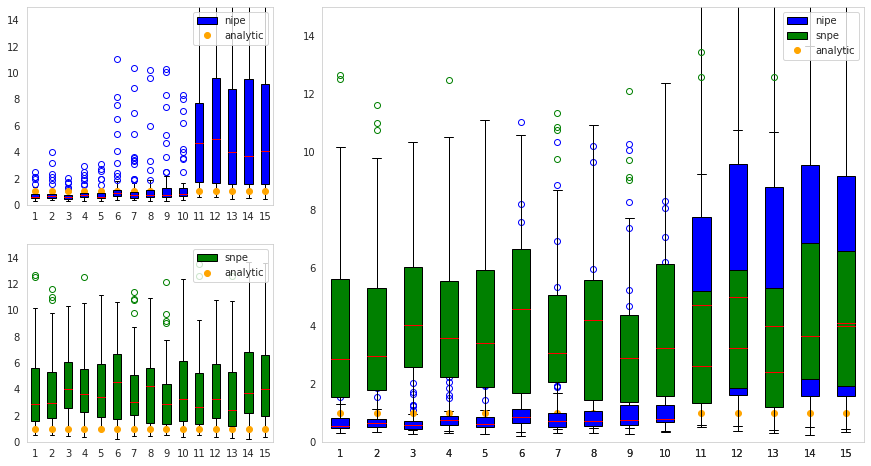

In [60]:
### plot variances:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
            flierprops=dict(color='blue', markeredgecolor='blue'))

axes['A'].set_ylim(0,15)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
axes['B'].set_ylim(0,15)


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'), flierprops=dict(color='blue', markeredgecolor='blue'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.stddev[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
axes['C'].set_ylim(0,15)

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper right')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper right')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')

In [91]:
nipe_array = torch.stack(([mean_list[i] for i in range(1, 59)]), dim=1)


snpe_array = torch.stack(([mean_list_snpe[i] for i in range(1, 59)]), dim=1)

In [93]:
analytic.mean

tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])

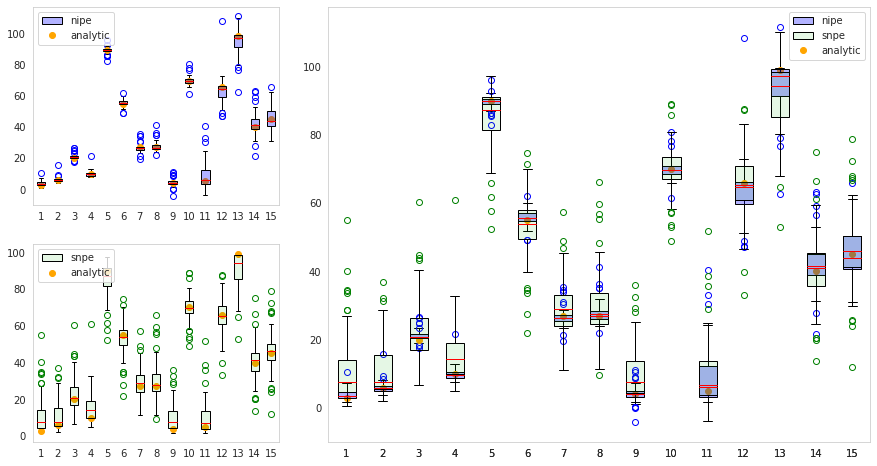

In [115]:
### plot means:
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

#axes['A'].plot(variance_list[58],'o', label='nipe', c='blue')

nipe_box  = axes['A'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'),            
            flierprops=dict(color='blue', markeredgecolor='blue'))

[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box['boxes']]

#axes['A'].set_ylim(0,15)

snpe_box = axes['B'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'),flierprops=dict(color='green', markeredgecolor='green'),)
#axes['B'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box['boxes']]


#axes['A'].plot(variance_list[59],'o', label='nipe', c='blue')
#axes['A'].plot(variance_list[57],'o', label='nipe', c='blue')


nipe_box2 = axes['C'].boxplot(nipe_array, patch_artist=True, boxprops=dict(facecolor='blue'), medianprops=dict(color='red'), flierprops=dict(color='blue', markeredgecolor='blue'),)

ana_plot = axes['A'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['B'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')
axes['C'].plot(np.linspace(1,15, 15), analytic.mean[0], 'o', c='orange', label='analytic')

#axes['B'].plot(variance_list_snpe[59],'o', c='g', label = 'snpe')
snpe_box2 = axes['C'].boxplot(snpe_array, patch_artist=True, boxprops=dict(facecolor='green'), medianprops=dict(color='red'), flierprops=dict(color='green', markeredgecolor='green'),)
#axes['C'].set_ylim(0,15)

[patch.set(alpha=None, facecolor=(0,0.7,0,.1)) for patch in snpe_box2['boxes']]
[patch.set(alpha=None, facecolor=(0.,0.,1,.3)) for patch in nipe_box2['boxes']]

axes['C'].legend()

axes['B'].legend([snpe_box['boxes'][0], ana_plot[0]], ['snpe', 'analytic'], loc='upper left')
axes['A'].legend([nipe_box['boxes'][0], ana_plot[0]], ['nipe',  'analytic'], loc='upper left')
axes['C'].legend([nipe_box['boxes'][0], snpe_box['boxes'][0], ana_plot[0]], ['nipe', 'snpe', 'analytic'], loc='upper right')

In [88]:
Gaussian(true_thetas[0, 0:])

tensor([  5.6454,   5.7505,  19.2827,   9.4505,  90.3711,  54.3027,  25.7367,
         28.6392,   2.7599,  71.5136,   5.1411,  64.9379, 100.6664,  39.7965,
         43.9925], dtype=torch.float64)

In [38]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [39]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [40]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

Text(0.5, 0, 'simulations per round')

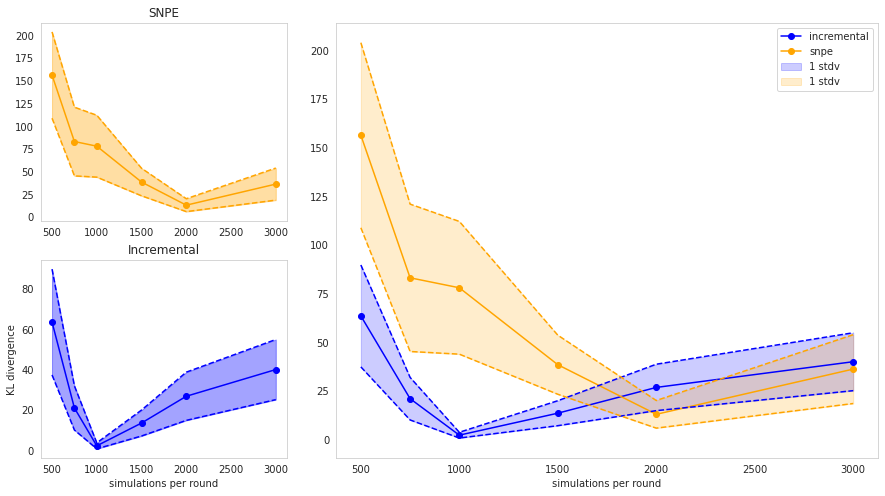

In [41]:
figure_mosaic = """
ACC
BCC
"""

fig, axes = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(15, 8))

    

axes['B'].plot(num_simulations_list, mean_incremental, '-o', color='blue')
axes['A'].plot(num_simulations_list, mean_snpe, '-o',  color='orange')

axes['B'].plot(num_simulations_list, upper_incremental, '--', color='blue')
axes['A'].plot(num_simulations_list, upper_snpe, '--',  color='orange')

axes['B'].plot(num_simulations_list, lower_incremental, '--', color='blue')
axes['A'].plot(num_simulations_list, lower_snpe, '--',  color='orange')


axes['C'].plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='blue')
axes['C'].plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='orange')

axes['C'].plot(num_simulations_list, upper_incremental, '--', color='blue')
axes['C'].plot(num_simulations_list, upper_snpe, '--',  color='orange')

axes['C'].plot(num_simulations_list, lower_incremental, '--',  color='blue')
axes['C'].plot(num_simulations_list, lower_snpe, '--',  color='orange')


axes['C'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2,  label='1 stdv')
axes['C'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2, label='1 stdv')


axes['B'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2)
axes['A'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2)


axes['B'].fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2)
axes['A'].fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2)


#plt.title('KL loss')
#axes['A'].legend()
#axes['B'].legend()
axes['C'].legend()

plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

axes['A'].set_title('SNPE')
axes['B'].set_title('Incremental')

#axes['A'].set_ylim((-5, 120))
#axes['B'].set_ylim((-5, 120))
#axes['C'].set_ylim((-5, 120))

axes['C'].set_xlabel('simulations per round')


#axes['B'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['A'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#axes['C'].set_xticklabels(['0k','2k', '4k', '6k', '8k', '10k'])
#plt.xticks(['1k', '3k', '5k', '10k'])

In [12]:
from sbi.analysis.sbc import check_sbc, run_sbc, get_nltp
from sbi.analysis.plot import sbc_rank_plot
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

In [13]:
#thetas = torch.stack(([samples_prior[i] for i in range(len(samples_prior))]))
xs = samples_prior

In [14]:
xs.shape

torch.Size([10000, 15])

In [15]:
posterior = list_collection_inc[0][0]

In [16]:
posterior_samples = posterior.sample((10,))


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
for idx, (tho, xo) in enumerate(zip(thetas, xs)):
    print(tho.shape)

torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15

torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15

torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15

torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15])
torch.Size([15

In [18]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 300
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_posterior_samples=num_posterior_samples)

Running 10000 sbc samples.:   0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: sample() got an unexpected keyword argument 'context'

In [ ]:
check_stats = check_sbc(ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples)


print(f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}")

In [2]:
print(f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}")
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")


NameError: name 'check_stats' is not defined

In [3]:
from sbi.analysis.plot import sbc_rank_plot

f, ax = sbc_rank_plot(ranks=ranks,
                      num_posterior_samples=num_posterior_samples,
                      plot_type="hist",
                      num_bins=10 # by passing None we use a heuristic for the number of bins.
                      )

NameError: name 'ranks' is not defined

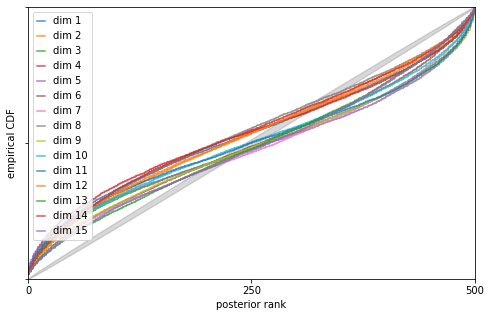

In [54]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "cdf")